# ResNet-50 Model summary

Get familiar with your model, by examining its structure and properties.

Use this notebook to display statics and information about the weights, layers and connectivity of the model.<br>

## Table of Contents

1. [Choose which model you want to examine](#Choose-which-model-you-want-to-examine)
2. [Print a summary of the statistics of the model attributes in tabular format](#Print-a-summary-of-the-statistics-of-the-model-attributes-in-tabular-format)<br>
    2.1. [Display some information about the layer types](#Display-some-information-about-the-layer-types)<br>
    2.2. [Compare weights footprint to feature-map footprint](#Compare-weights-footprint-to-feature-map-footprint)<br>
    2.3. [Compare data footprint to compute (MACs)](#Compare-data-footprint-to-compute-(MACs)
3. [Filter L1-norm](#Filter-L1-norm)
4. [References](#References)

In [1]:
# Relative import of code from distiller, w/o installing the package
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
    
from distiller.model_summaries import *
from models import create_model
from apputils import *
import torch
import torchvision
import qgrid

# Load some common jupyter code
%run distiller_jupyter_helpers.ipynb
import ipywidgets as widgets
from ipywidgets import interactive, interact, Layout

# Some models have long node names and require longer lines
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

def pretty_int(i):
    return "{:,}".format(i)

## Choose which model you want to examine

If you are studying the structure of a neural network model, you probably don't need a pruned model, although you can use one.
<br>
In this example, we look at a pretrained ResNet18 model.

In [2]:
dataset = 'imagenet'
dummy_input = Variable(torch.randn(1, 3, 224, 224), requires_grad=False)
arch = 'resnet50'

checkpoint_file = None 

if checkpoint_file is not None:
    model = create_model(pretrained=True, dataset=dataset, arch=arch)
    load_checkpoint(model, checkpoint_file)
else:
    model = create_model(pretrained=True, dataset=dataset, arch=arch, parallel=False)

## Print a summary of the statistics of the model attributes in tabular format

Distiller generates several different summary reports, which are returned as Pandas dataframes which you can slice, dice and sort using Pandas' rich API.<br>
<br>
MACs are multiply-accumulate operations: a MAC unit computes the product of two elements and adds the product to an accumulator.  The MACs reported by distiller.model_performance_summary are for direct GEMM (General Matrix-Matrix Multiplication) and convolution.  Different hardware uses specific algorithms at different times.  For example, [Intel's MKL-DNN](https://intel.github.io/mkl-dnn/) uses [Winograd](https://arxiv.org/pdf/1509.09308.pdf) for 3x3 convolutions.  As another example, [convolutions are sometimes computed using GEMM](https://petewarden.com/2015/04/20/why-gemm-is-at-the-heart-of-deep-learning/) for increased utilization of vectorized hardware.<br>


<br>
In the example below, we display some statistics about the sizes and shapes of the feature-maps and weight tensors, and some other goodies. :-)

In [3]:
df = distiller.model_performance_summary(model, dummy_input, 1)

# You can display summaries using several backends, and each has its advantages and disadvantages, so you will want to use them in different situations.
print("Weights shapes, sizes and statistics (showing only FC and convolution layers):")
print("\tTotal IFM footprint (elements): " + "{:,}".format(df['IFM volume'].sum()))
print("\tTotal OFM footprint (elements): " + "{:,}".format(df['OFM volume'].sum()))
print("\tTotal weights footprint (elements): " + "{:,}".format(df['Weights volume'].sum()))
print("\tTotal MACs: " + "{:,}".format(df['MACs'].sum()))

Weights shapes, sizes and statistics (showing only FC and convolution layers):
	Total IFM footprint (elements): 10,664,448
	Total OFM footprint (elements): 11,114,984
	Total weights footprint (elements): 25,502,912
	Total MACs: 4,089,184,256


In [4]:
df['MACs'].unique()

array([118013952, 12845056, 115605504, 51380224, 102760448, 2048000],
      dtype=object)

In [5]:
len(df.loc[df['MACs'] == 102760448])
df.loc[df['MACs'] == 102760448] #Only 3 in caffe

,Name,Type,Attrs,IFM,IFM volume,OFM,OFM volume,Weights volume,MACs
11,layer2.0.conv1,Conv2d,"k=(1, 1)","(1, 256, 56, 56)",802816,"(1, 128, 56, 56)",401408,32768,102760448
14,layer2.0.downsample.0,Conv2d,"k=(1, 1)","(1, 256, 56, 56)",802816,"(1, 512, 28, 28)",401408,131072,102760448
24,layer3.0.conv1,Conv2d,"k=(1, 1)","(1, 512, 28, 28)",401408,"(1, 256, 28, 28)",200704,131072,102760448
27,layer3.0.downsample.0,Conv2d,"k=(1, 1)","(1, 512, 28, 28)",401408,"(1, 1024, 14, 14)",200704,524288,102760448
43,layer4.0.conv1,Conv2d,"k=(1, 1)","(1, 1024, 14, 14)",200704,"(1, 512, 14, 14)",100352,524288,102760448
46,layer4.0.downsample.0,Conv2d,"k=(1, 1)","(1, 1024, 14, 14)",200704,"(1, 2048, 7, 7)",100352,2097152,102760448


In [6]:
# 1. As a textual table
t = distiller.model_performance_tbl_summary(model, dummy_input, 1)
print(t)

+----+-----------------------+--------+----------+-------------------+--------------+-------------------+--------------+------------------+-----------+
|    | Name                  | Type   | Attrs    | IFM               |   IFM volume | OFM               |   OFM volume |   Weights volume |      MACs |
|----+-----------------------+--------+----------+-------------------+--------------+-------------------+--------------+------------------+-----------|
|  0 | conv1                 | Conv2d | k=(7, 7) | (1, 3, 224, 224)  |       150528 | (1, 64, 112, 112) |       802816 |             9408 | 118013952 |
|  1 | layer1.0.conv1        | Conv2d | k=(1, 1) | (1, 64, 56, 56)   |       200704 | (1, 64, 56, 56)   |       200704 |             4096 |  12845056 |
|  2 | layer1.0.conv2        | Conv2d | k=(3, 3) | (1, 64, 56, 56)   |       200704 | (1, 64, 56, 56)   |       200704 |            36864 | 115605504 |
|  3 | layer1.0.conv3        | Conv2d | k=(1, 1) | (1, 64, 56, 56)   |       200704 | (1

In [7]:
# 2. As a plain Pandas dataframe
display(df)

,Name,Type,Attrs,IFM,IFM volume,OFM,OFM volume,Weights volume,MACs
0,conv1,Conv2d,"k=(7, 7)","(1, 3, 224, 224)",150528,"(1, 64, 112, 112)",802816,9408,118013952
1,layer1.0.conv1,Conv2d,"k=(1, 1)","(1, 64, 56, 56)",200704,"(1, 64, 56, 56)",200704,4096,12845056
2,layer1.0.conv2,Conv2d,"k=(3, 3)","(1, 64, 56, 56)",200704,"(1, 64, 56, 56)",200704,36864,115605504
3,layer1.0.conv3,Conv2d,"k=(1, 1)","(1, 64, 56, 56)",200704,"(1, 256, 56, 56)",802816,16384,51380224
4,layer1.0.downsample.0,Conv2d,"k=(1, 1)","(1, 64, 56, 56)",200704,"(1, 256, 56, 56)",802816,16384,51380224
5,layer1.1.conv1,Conv2d,"k=(1, 1)","(1, 256, 56, 56)",802816,"(1, 64, 56, 56)",200704,16384,51380224
6,layer1.1.conv2,Conv2d,"k=(3, 3)","(1, 64, 56, 56)",200704,"(1, 64, 56, 56)",200704,36864,115605504
7,layer1.1.conv3,Conv2d,"k=(1, 1)","(1, 64, 56, 56)",200704,"(1, 256, 56, 56)",802816,16384,51380224
8,layer1.2.conv1,Conv2d,"k=(1, 1)","(1, 256, 56, 56)",802816,"(1, 64, 56, 56)",200704,16384,51380224
9,layer1.2.conv2,Conv2d,"k=(3, 3)","(1, 64, 56, 56)",200704,"(1, 64, 56, 56)",200704,36864,115605504


In [8]:
# 3. As a QGrid table, which you can sort and filter.
# Doesn't display anything
# TODO: REvisit 
# qgrid.show_grid(df)

### Display some information about the layer types
Gleaning model statistics using Pandas dataframes, provides a painless way to query 2nd level details about the model, such as what layer types it uses.

In [9]:
conv7x7 = df[df['Attrs'] == 'k=(7, 7)']
conv3x3 = df[df['Attrs'] == 'k=(3, 3)']
conv1x1 = df[df['Attrs'] == 'k=(1, 1)']

print("There are %d Conv(7,7) layers with total MACs = %s" % (len(conv7x7), pretty_int(conv7x7['MACs'].sum())))
print("There are %d Conv(3,3) layers with total MACs = %s" % (len(conv3x3), pretty_int(conv3x3['MACs'].sum())))
print("There are %d Conv(1,1) layers with total MACs = %s" % (len(conv1x1), pretty_int(conv1x1['MACs'].sum())))

There are 1 Conv(7,7) layers with total MACs = 118,013,952
There are 16 Conv(3,3) layers with total MACs = 1,849,688,064
There are 36 Conv(1,1) layers with total MACs = 2,119,434,240


### Compare weights footprint to feature-map footprint

Memory footprint, bandwidth and throughput are different concepts.  Footprint is the size amount of memory required to store a piece of data (e.g. measured as number of bytes).  Bandwidth is the rate at which data can be read or written (stored) from/to memory by different hardware (e.g. measured as bytes/sec).  Throughput is a measure of the data that actually moves (read/stored) in a period of time (bytes/sec).<br>
Because the amount of data required for a typical neural-network operation is often larger than the available working memory of the compute hardware (e.g. CPU registers and cache), data often needs to be sliced into tiles (blocks).  The sizes of the tiles, together with the memory access pattern and the compute algorithm, determine the total amount of data that needs to move around (read/stored).  Because of this hardware dependency, we provide below information regarding memory footprint and not throughput.

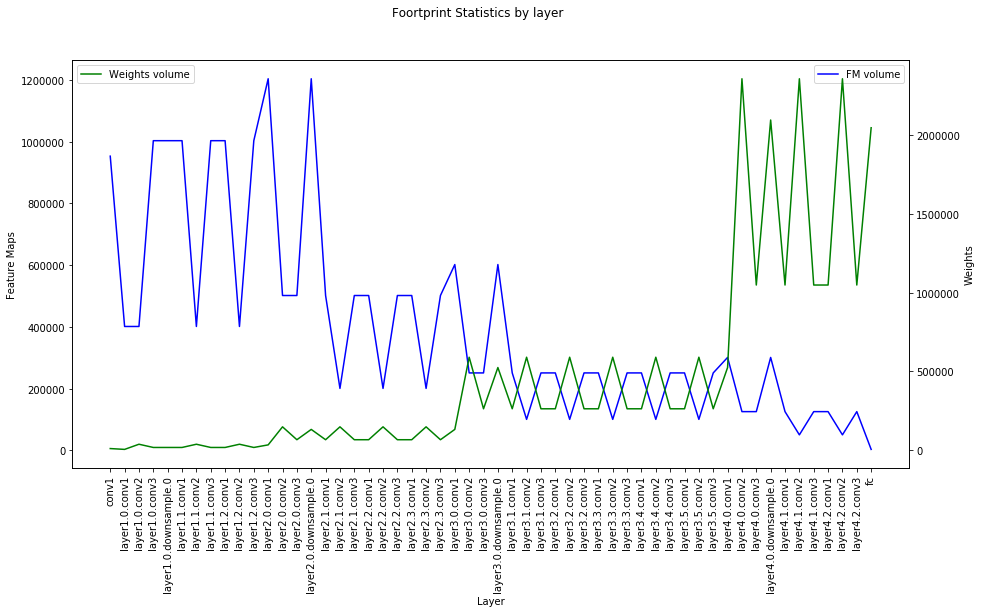

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,7.5))
fig.suptitle("Foortprint Statistics by layer")
ax.set_ylabel("Feature Maps")
ax.set_xlabel("Layer")
ax2 = ax.twinx()
ax2.set_ylabel("Weights")
ax.set_xticklabels(df.Name, rotation=90);

df["FM volume"] = df["OFM volume"] + df["IFM volume"]
df[["Name","FM volume"]].plot(ax=ax, xticks=range(len(df.index)), style="b-", rot=90)
df[["Name","Weights volume"]].plot(ax=ax2, style="g-", use_index=True, rot=90);


### Compare data footprint to compute (MACs)

We measure Footprint in number of elements, not bytes.  If, for example, the elements data type is FP32, then the real footprint is 4x the reported footprint.

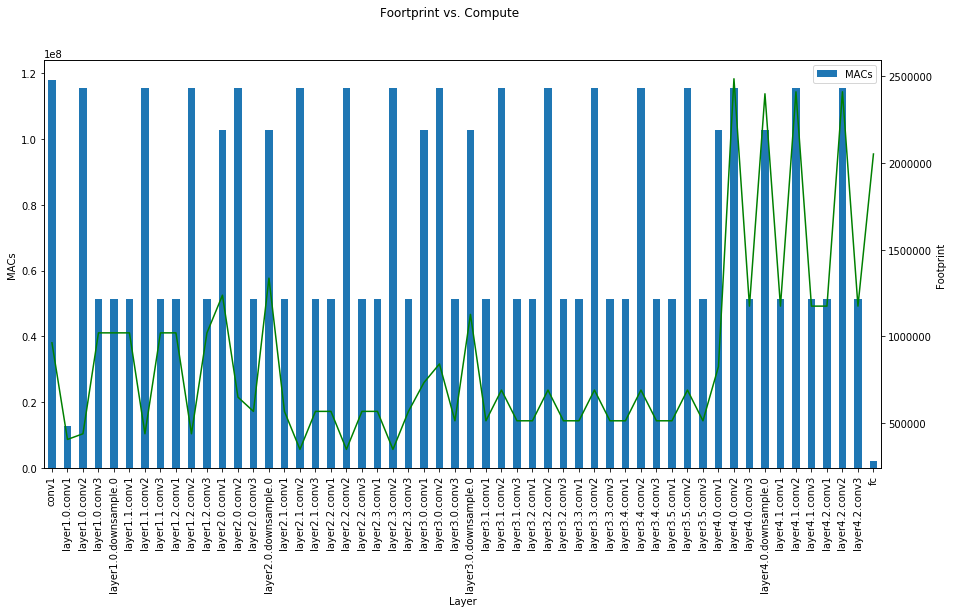

In [11]:
fig, ax = plt.subplots(figsize=(15,7.5))
fig.suptitle("Foortprint vs. Compute")
ax.set_ylabel("MACs")
ax.set_xlabel("Layer")
ax2 = ax.twinx()
ax2.set_ylabel("Footprint")

df[["Name", "MACs"]].plot(ax=ax, kind='bar', rot=90,  xticks=range(len(df.index)), figsize=[15,7.5])
ax.set_xticklabels(df.Name, rotation=90);

df2 = df["Weights volume"] + df["OFM volume"] + df["IFM volume"]
df2.plot(ax=ax2, style="g-", use_index=True, rot=90);

## Filter L1-norm

Draw the L1 norm of each filter, in a selected weight tensor.<br>
When ranking filters by L1-norm (as in [Pruning filters for efficient convnets](#Hao-et-al-2016)), this can provide some insight as to which filters will be removed.<br>
Make sure you've loaded a pretrained network, otherwise you will be looking at random data.

In [12]:
params_names = conv_param_names(model)

def view_weights(pname, sort):
    param = model.state_dict()[pname]
    view_filters = param.view(param.size(0), -1)
    filter_mags = to_np(view_filters.abs().mean(dim=1))
    if sort:
        filter_mags = np.sort(filter_mags)
    plt.figure(figsize=[15,7.5])
    plt.plot(range(len(filter_mags)), filter_mags, label=pname, marker="o", markersize=5, markerfacecolor="C1")
    plt.xlabel('Filter index (i.e. output feature-map channel)')
    plt.ylabel('Fliter L1-norm')

sort_choice = widgets.Checkbox(value=True, description='Sort filters')
params_dropdown = widgets.Dropdown(description='Weights:', options=params_names, layout=Layout(width='40%'))
interact(view_weights, pname=params_dropdown, sort=sort_choice);

interactive(children=(Dropdown(description='Weights:', layout=Layout(width='40%'), options=('conv1.weight', 'layer1.0.conv1.weight', 'layer1.0.conv2.weight', 'layer1.0.conv3.weight', 'layer1.0.downsample.0.weight', 'layer1.1.conv1.weight', 'layer1.1.conv2.weight', 'layer1.1.conv3.weight', 'layer1.2.conv1.weight', 'layer1.2.conv2.weight', 'layer1.2.conv3.weight', 'layer2.0.conv1.weight', 'layer2.0.conv2.weight', 'layer2.0.conv3.weight', 'layer2.0.downsample.0.weight', 'layer2.1.conv1.weight', 'layer2.1.conv2.weight', 'layer2.1.conv3.weight', 'layer2.2.conv1.weight', 'layer2.2.conv2.weight', 'layer2.2.conv3.weight', 'layer2.3.conv1.weight', 'layer2.3.conv2.weight', 'layer2.3.conv3.weight', 'layer3.0.conv1.weight', 'layer3.0.conv2.weight', 'layer3.0.conv3.weight', 'layer3.0.downsample.0.weight', 'layer3.1.conv1.weight', 'layer3.1.conv2.weight', 'layer3.1.conv3.weight', 'layer3.2.conv1.weight', 'layer3.2.conv2.weight', 'layer3.2.conv3.weight', 'layer3.3.conv1.weight', 'layer3.3.conv2.weight', 'layer3.3.conv3.weight', 'layer3.4.conv1.weight', 'layer3.4.conv2.weight', 'layer3.4.conv3.weight', 'layer3.5.conv1.weight', 'layer3.5.conv2.weight', 'layer3.5.conv3.weight', 'layer4.0.conv1.weight', 'layer4.0.conv2.weight', 'layer4.0.conv3.weight', 'layer4.0.downsample.0.weight', 'layer4.1.conv1.weight', 'layer4.1.conv2.weight', 'layer4.1.conv3.weight', 'layer4.2.conv1.weight', 'layer4.2.conv2.weight', 'layer4.2.conv3.weight'), value='conv1.weight'), Checkbox(value=True, description='Sort filters'), Output()), _dom_classes=('widget-interact',))

## References

<div id="Gray-et-al-2015"></div> **Andrew Lavin and Scott Gray**. 
    [*Fast Algorithms for Convolutional Neural Networks*](https://arxiv.org/pdf/1509.09308.pdf),
    2015.
<div id="Hao-et-al-2016"></div> **Hao Li, Asim Kadav, Igor Durdanovic, Hanan Samet, and Hans Peter Graf**. 
    [*Pruning filters for efficient convnets*](https://arxiv.org/abs/1608.08710),
    2016.